<a href="https://colab.research.google.com/github/Gladwin-George/Basel-Climate-Dataset/blob/main/Task_1_Climatebaseldataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Task 1: Basel Climate Dataset**
---


---



## **Dataset: ClimateDataBasel.csv**

This notebook explores unsupervised learning techniques to identify underlying patterns in climate data collected in Basel, Switzerland. The dataset consists of multivariate meteorological measurements, which are preprocessed to ensure robustness and suitability for clustering analysis.

The workflow includes:

* loading and inspecting the Basel climate dataset,

* detecting and removing extreme outliers using Isolation Forest,

* scaling and feature selection to reduce redundancy,

* applying PCA for dimensionality reduction,

* performing clustering using K-Means, DBSCAN, and Gaussian Mixture Models,

* evaluating clustering performance using internal validation metrics and visual analysis.

# Disclaimer:
This code was originally developed and tested in Google Colab, where datasets and outputs are accessed via Google Drive paths (e.g., /content/drive/MyDrive/...).
When running this notebook locally (e.g., in VS Code or a system Python environment), file paths must be updated accordingly to point to local directories where the dataset and output files are stored. No other changes to the methodology or implementation are required

# Mounting Google Drive

Mounts your Google Drive inside Colab so you can read datasets and save outputs (For colab).

In [69]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Imported necessary libraries
This section imports the required Python libraries for data handling, preprocessing, clustering, and evaluation.

In [70]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA

from sklearn.cluster import KMeans, DBSCAN
from sklearn.mixture import GaussianMixture

from sklearn.neighbors import NearestNeighbors

from sklearn.ensemble import IsolationForest

from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score
)

# Data Loading and Preprocessing

* Loaded the Basel climate dataset and assigned descriptive feature names.

* Performed basic data inspection to check for missing values and duplicates.

* Detected and removed extreme outliers using Isolation Forest.

* Scaled the cleaned data using RobustScaler to reduce the impact of outliers.

* Identified and removed highly correlated features to minimise redundancy.

* Rescaled the selected features to prepare the data for further analysis.

In [71]:
# Path to the CSV file
file_path = '/content/drive/MyDrive/task1/data/ClimateDataBasel.csv'

In [72]:
df = pd.read_csv(file_path, header=None)

# Assign names
df.columns = [
    "temp_min", "temp_max", "temp_mean",
    "rh_min", "rh_max", "rh_mean",
    "slp_min", "slp_max", "slp_mean",
    "precip_total", "snowfall_amount", "sunshine_duration",
    "gust_min", "gust_max", "gust_mean",
    "wind_min", "wind_max", "wind_mean"
]

print(df.head())

    temp_min   temp_max  temp_mean  rh_min  rh_max    rh_mean  slp_min  \
0   8.100529  17.570530  13.445111      61      96  77.875000   1013.1   
1  11.110529  18.490528  14.988861      59      94  76.458336   1013.9   
2  10.320529  18.170528  14.267612      71      96  83.583336   1015.3   
3  10.450529  24.980530  17.309278      54      92  77.625000   1015.9   
4  12.350529  25.610529  19.881780      47      88  66.583336   1015.7   

   slp_max    slp_mean  precip_total  snowfall_amount  sunshine_duration  \
0   1018.4  1015.75830           0.2              0.0          350.56274   
1   1016.6  1014.99170           1.9              0.0          287.23404   
2   1017.5  1016.38745           0.1              0.0          126.26506   
3   1018.7  1017.26250           0.0              0.0          881.24710   
4   1020.7  1018.18353           0.0              0.0          951.56665   

   gust_min   gust_max  gust_mean  wind_min   wind_max  wind_mean  
0  3.240000  23.400000  12.210

In [73]:
print("Missing values per column:\n", df.isna().sum())
print("Duplicates:", df.duplicated().sum())

Missing values per column:
 temp_min             0
temp_max             0
temp_mean            0
rh_min               0
rh_max               0
rh_mean              0
slp_min              0
slp_max              0
slp_mean             0
precip_total         0
snowfall_amount      0
sunshine_duration    0
gust_min             0
gust_max             0
gust_mean            0
wind_min             0
wind_max             0
wind_mean            0
dtype: int64
Duplicates: 0


In [74]:
X_raw = df.values

iso = IsolationForest(
    n_estimators=300,
    contamination=0.02,
    random_state=42
)
outlier_flag = iso.fit_predict(X_raw)

df_clean = df[outlier_flag == 1].copy()
print("Original:", df.shape, "After outlier removal:", df_clean.shape)


Original: (1763, 18) After outlier removal: (1727, 18)


In [75]:
X = df_clean.values

scaler = RobustScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled shape:", X_scaled.shape)


Scaled shape: (1727, 18)


In [76]:
corr = df_clean.corr().abs()
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

to_drop = [col for col in upper.columns if any(upper[col] > 0.95)]
print("Dropping highly correlated features:", to_drop)

df_fs = df_clean.drop(columns=to_drop)
X_fs = df_fs.values

scaler = RobustScaler()
X_fs_scaled = scaler.fit_transform(X_fs)

print("After feature selection:", X_fs_scaled.shape)


Dropping highly correlated features: ['temp_max', 'temp_mean', 'slp_mean']
After feature selection: (1727, 15)


# Dimensionality Reduction using PCA

* Applied Principal Component Analysis (PCA) to the scaled feature set to analyse variance distribution.

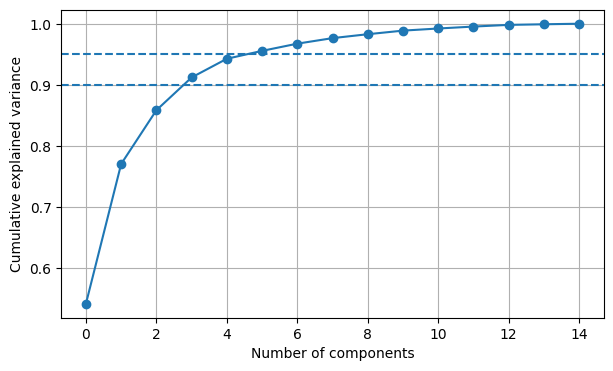

PCA components for 95% variance: 6
X_pca shape: (1727, 6)


In [77]:
pca_full = PCA(random_state=42)
X_pca_full = pca_full.fit_transform(X_fs_scaled)

cumvar = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(7,4))
plt.plot(cumvar, marker='o')
plt.axhline(0.90, linestyle='--')
plt.axhline(0.95, linestyle='--')
plt.xlabel("Number of components")
plt.ylabel("Cumulative explained variance")
plt.grid(True)
plt.show()

k_pca = int(np.argmax(cumvar >= 0.95) + 1)
print("PCA components for 95% variance:", k_pca)

pca = PCA(n_components=k_pca, random_state=42)
X_pca = pca.fit_transform(X_fs_scaled)
print("X_pca shape:", X_pca.shape)


# K-Means Clustering and Evaluation

* Applied K-Means clustering for values of k ranging from 2 to 10 on the PCA-reduced data.

* Evaluated clustering quality using Silhouette Score, Davies–Bouldin Index, and Calinski–Harabasz Index.

* Selected the optimal number of clusters based on the highest Silhouette Score.

* Trained the final K-Means model using the selected k and visualised the final K-Means clustering using a 2D PCA projection

* Reported internal validation metrics to assess clustering performance.

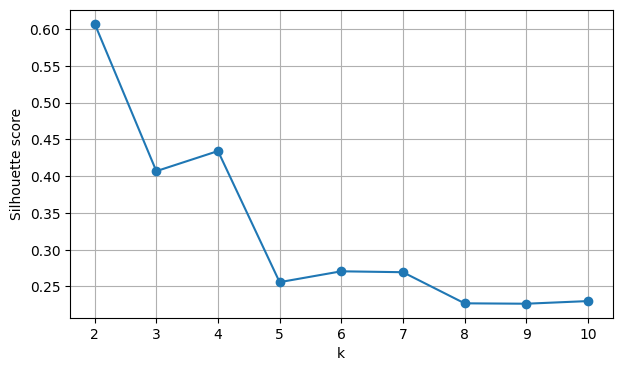

Best k by silhouette: 2

KMeans Evaluation Metrics
KMeans Silhouette: 0.6074618073517418
KMeans Davies-Bouldin: 0.75589782391207
KMeans Calinski-Harabasz: 1030.1885474899084


In [78]:
sil_scores = []
db_scores = []
ch_scores = []
ks = range(2, 11)

for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = km.fit_predict(X_pca)
    sil_scores.append(silhouette_score(X_pca, labels))
    db_scores.append(davies_bouldin_score(X_pca, labels))
    ch_scores.append(calinski_harabasz_score(X_pca, labels))

plt.figure(figsize=(7,4))
plt.plot(list(ks), sil_scores, marker='o')
plt.xlabel("k")
plt.ylabel("Silhouette score")
plt.grid(True)
plt.show()

best_k = ks[int(np.argmax(sil_scores))]
print("Best k by silhouette:", best_k)

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=20)
kmeans_labels = kmeans.fit_predict(X_pca)

k_means_sil = silhouette_score(X_pca, kmeans_labels)
k_means_dbi = davies_bouldin_score(X_pca, kmeans_labels)
k_means_chi = calinski_harabasz_score(X_pca, kmeans_labels)

print("\nKMeans Evaluation Metrics")
print("KMeans Silhouette:", k_means_sil)
print("KMeans Davies-Bouldin:",k_means_dbi)
print("KMeans Calinski-Harabasz:", k_means_chi)


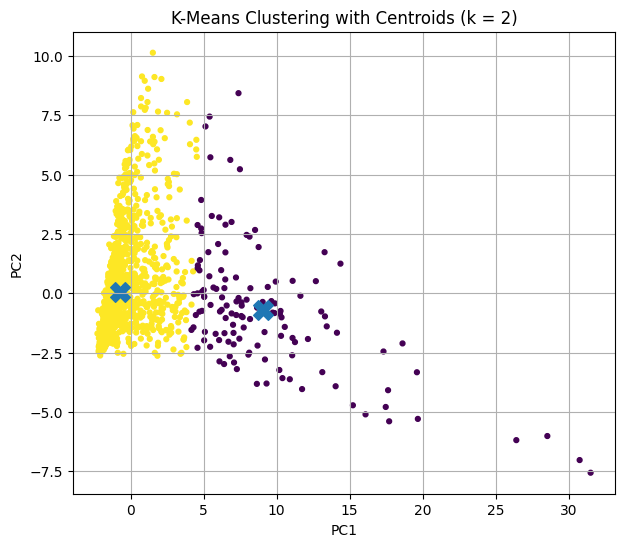

In [96]:
centroids_2d = pca_2d.transform(kmeans.cluster_centers_)

plt.figure(figsize=(7, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=kmeans_labels, s=12)
plt.scatter(
    centroids_2d[:, 0],
    centroids_2d[:, 1],
    marker='X',
    s=200
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"K-Means Clustering with Centroids (k = {best_k})")
plt.grid(True)
plt.show()


# Saving Clustering Evaluation Results

In [79]:
csv_path = "/content/drive/MyDrive/task1/clustering_scores/clustering_scores.csv"

if os.path.exists(csv_path):
    model_scores_df = pd.read_csv(csv_path)
else:
    model_scores_df = pd.DataFrame(columns=[
        "Model",
        "Silhouette Score",
        "Davies-Bouldin",
        "Calinski-Harabasz"
    ])

In [80]:
model_scores_df.loc[len(model_scores_df)] = [
    "K-Means",
    k_means_sil,
    k_means_dbi,
    k_means_chi
]

model_scores_df.to_csv(csv_path, index=False)
model_scores_df

,Model,Silhouette Score,Davies-Bouldin,Calinski-Harabasz
0,K-Means,0.607462,0.755898,1030.188547


# DBSCAN Clustering and Evaluation

* Applied DBSCAN clustering using the original dataset without prior outlier removal to preserve density structure.

* Scaled the data using RobustScaler and reduced it to two dimensions using PCA for efficient distance computation and visualisation.

* Used k-distance analysis to guide the selection of the eps parameter.

* Evaluated multiple eps values and analysed the number of clusters, noise percentage, and Silhouette Score.

* Trained the final DBSCAN model using the selected parameters.

* Evaluated clustering performance using Silhouette Score, Davies Bouldin Index, and Calinski Harabasz Index (excluding noise points).

* Saved DBSCAN evaluation metrics for comparison with other clustering models.

In [81]:
# Use ORIGINAL data with no IsolationForest
X_db = df.values

scaler_db = RobustScaler()
X_db_scaled = scaler_db.fit_transform(X_db)

pca_db = PCA(n_components=2, random_state=42)
X_db_pca = pca_db.fit_transform(X_db_scaled)

print("DBSCAN PCA shape:", X_db_pca.shape)


DBSCAN PCA shape: (1763, 2)


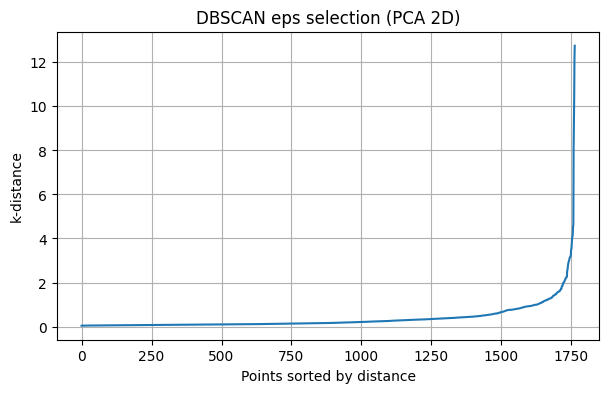

In [82]:
min_samples = 10

nbrs = NearestNeighbors(n_neighbors=min_samples)
nbrs.fit(X_db_pca)

distances, _ = nbrs.kneighbors(X_db_pca)
k_distances = np.sort(distances[:, min_samples - 1])

plt.figure(figsize=(7,4))
plt.plot(k_distances)
plt.xlabel("Points sorted by distance")
plt.ylabel("k-distance")
plt.title("DBSCAN eps selection (PCA 2D)")
plt.grid(True)
plt.show()

In [83]:
eps_values = np.arange(0.1, 1.1, 0.05)
results = []

for eps in eps_values:
    db = DBSCAN(eps=eps, min_samples=10)
    labels = db.fit_predict(X_db_pca)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_pct = np.mean(labels == -1) * 100

    if n_clusters >= 2:
        valid = labels != -1
        sil = silhouette_score(X_db_pca[valid], labels[valid])
    else:
        sil = np.nan

    results.append({
        "eps": eps,
        "clusters": n_clusters,
        "noise_pct": noise_pct,
        "silhouette": sil
    })

results_df = pd.DataFrame(results)
results_df.sort_values("silhouette", ascending=False).head(10)


,eps,clusters,noise_pct,silhouette
11,0.65,2,12.081679,0.684099
13,0.75,3,10.209870,0.669672
3,0.25,2,33.238798,0.582354
12,0.70,3,11.003971,0.556291
4,0.30,3,27.736812,0.520719
14,0.80,4,7.657402,0.514043
1,0.15,2,45.377198,0.503644
15,0.85,3,6.806580,0.492231
16,0.90,3,6.409529,0.486240
17,0.95,3,5.331821,0.474790


In [84]:
best_eps = 0.65
min_samples = 10

dbscan = DBSCAN(eps=best_eps, min_samples=min_samples)
db_labels = dbscan.fit_predict(X_db_pca)

n_clusters = len(set(db_labels)) - (1 if -1 in db_labels else 0)
noise_pct = np.mean(db_labels == -1) * 100

print("DBSCAN (final)")
print("Clusters:", n_clusters)
print("Noise (%):", noise_pct)


DBSCAN (final)
Clusters: 2
Noise (%): 12.081678956324447


In [85]:
valid = db_labels != -1

if len(np.unique(db_labels[valid])) > 1:
    dbscan_sil = silhouette_score(X_db_pca[valid], db_labels[valid])
    dbscan_dbi = davies_bouldin_score(X_db_pca[valid], db_labels[valid])
    dbscan_chi = calinski_harabasz_score(X_db_pca[valid], db_labels[valid])

    print("\nDBSCAN Evaluation Metrics (excluding noise)")
    print("Silhouette Score:", dbscan_sil)
    print("Davies–Bouldin Index:", dbscan_dbi)
    print("Calinski–Harabasz Index:", dbscan_chi)
else:
    print("\nNot enough clusters for metric evaluation")



DBSCAN Evaluation Metrics (excluding noise)
Silhouette Score: 0.6840990228262527
Davies–Bouldin Index: 0.2793838227209072
Calinski–Harabasz Index: 156.05889517567851


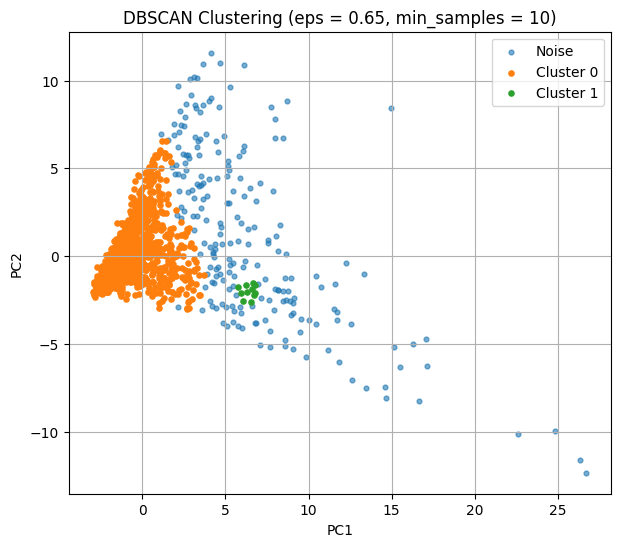

In [101]:
plt.figure(figsize=(7, 6))

# noise
plt.scatter(
    X_db_pca[db_labels == -1, 0],
    X_db_pca[db_labels == -1, 1],
    s=12,
    alpha=0.6,
    label="Noise"
)

# cluster
unique_clusters = sorted(set(db_labels) - {-1})

for cid in unique_clusters:
    plt.scatter(
        X_db_pca[db_labels == cid, 0],
        X_db_pca[db_labels == cid, 1],
        s=14,
        label=f"Cluster {cid}"
    )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title(f"DBSCAN Clustering (eps = {best_eps}, min_samples = {min_samples})")
plt.legend()
plt.grid(True)
plt.show()

In [86]:
model_scores_df.loc[len(model_scores_df)] = [
    "DBSCAN",
    dbscan_sil,
    dbscan_dbi,
    dbscan_chi
]

model_scores_df.to_csv(csv_path, index=False)

# Gaussian Mixture Model (GMM) Clustering and Evaluation

* Applied Gaussian Mixture Models (GMM) to the PCA-reduced feature space.

* Selected the optimal number of components by analysing AIC and BIC scores.

* Performed additional dimensionality reduction for stable metric evaluation.

* Evaluated different covariance types (full, tied, diagonal, spherical) using internal clustering metrics.

* Selected the best covariance structure based on the highest Silhouette Score.

* Trained the final GMM using the selected configuration.

* Assessed clustering performance using Silhouette Score, Davies Bouldin Index, and Calinski Harabasz Index.

* Visualised the final GMM clustering results using a two-dimensional PCA projection.

In [87]:
print("GMM fitting space shape:", X_pca.shape)


GMM fitting space shape: (1727, 6)


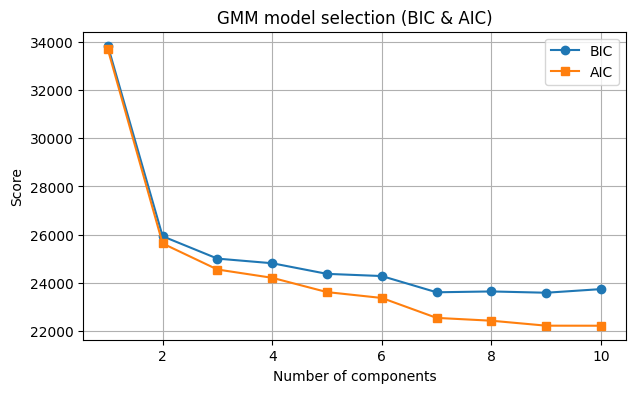

In [88]:
n_components_range = range(1, 11)
bic_scores = []
aic_scores = []

for n in n_components_range:
    gmm = GaussianMixture(
        n_components=n,
        covariance_type="full",
        random_state=42
    )
    gmm.fit(X_pca)
    bic_scores.append(gmm.bic(X_pca))
    aic_scores.append(gmm.aic(X_pca))

plt.figure(figsize=(7,4))
plt.plot(n_components_range, bic_scores, marker='o', label="BIC")
plt.plot(n_components_range, aic_scores, marker='s', label="AIC")
plt.xlabel("Number of components")
plt.ylabel("Score")
plt.title("GMM model selection (BIC & AIC)")
plt.legend()
plt.grid(True)
plt.show()



In [89]:
pca_eval = PCA(n_components=5, random_state=42)
X_pca_eval = pca_eval.fit_transform(X_fs_scaled)

print("Evaluation PCA shape:", X_pca_eval.shape)


Evaluation PCA shape: (1727, 5)


In [90]:
covariance_types = ["full", "tied", "diag", "spherical"]

best_n = 7
gmm_results = []

for cov in covariance_types:
    gmm = GaussianMixture(
        n_components=best_n,
        covariance_type=cov,
        random_state=42
    )
    labels = gmm.fit_predict(X_pca)

    sil = silhouette_score(X_pca_eval, labels)
    dbi = davies_bouldin_score(X_pca_eval, labels)
    chi = calinski_harabasz_score(X_pca_eval, labels)

    gmm_results.append({
        "covariance_type": cov,
        "silhouette": sil,
        "davies_bouldin": dbi,
        "calinski_harabasz": chi
    })

gmm_results_df = pd.DataFrame(gmm_results)
gmm_results_df


,covariance_type,silhouette,davies_bouldin,calinski_harabasz
0,full,0.096668,2.021834,354.582332
1,tied,0.220745,1.287985,710.806507
2,diag,0.188734,1.271866,715.790427
3,spherical,0.264985,1.144231,827.539317


In [91]:
best_row = gmm_results_df.sort_values("silhouette", ascending=False).iloc[0]
best_cov = best_row["covariance_type"]

print("Best covariance type:", best_cov)


Best covariance type: spherical


In [92]:
gmm_final = GaussianMixture(
    n_components=best_n,
    covariance_type=best_cov,
    random_state=42
)

gmm_labels = gmm_final.fit_predict(X_pca)

print("Final GMM clusters:", len(np.unique(gmm_labels)))


gmm_sil = silhouette_score(X_pca_eval, gmm_labels)
gmm_dbi = davies_bouldin_score(X_pca_eval, gmm_labels)
gmm_chi = calinski_harabasz_score(X_pca_eval, gmm_labels)

print("\nFinal GMM Evaluation Metrics")
print("Silhouette Score:", gmm_sil)
print("Davies–Bouldin Index:", gmm_dbi)
print("Calinski–Harabasz Index:", gmm_chi)



Final GMM clusters: 7

Final GMM Evaluation Metrics
Silhouette Score: 0.2649845186040879
Davies–Bouldin Index: 1.1442313460469893
Calinski–Harabasz Index: 827.5393165028518


In [93]:
model_scores_df.loc[len(model_scores_df)] = [
    "GMM",
    gmm_sil,
    gmm_dbi,
    gmm_chi
]

model_scores_df.to_csv(csv_path, index=False)

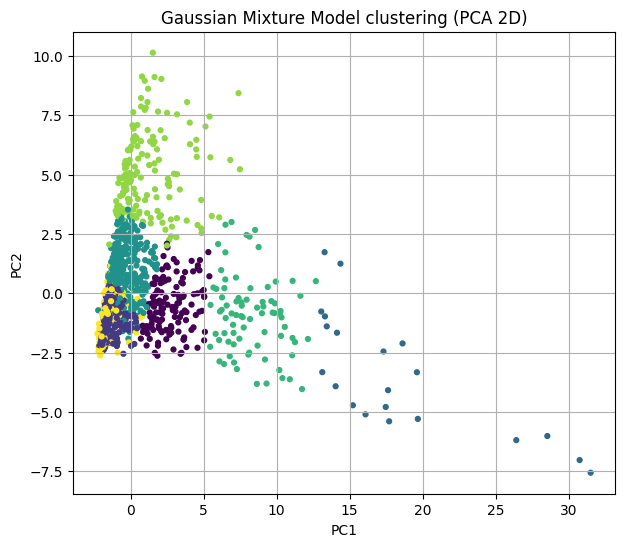

In [94]:
pca_2d = PCA(n_components=2, random_state=42)
X_2d = pca_2d.fit_transform(X_fs_scaled)

plt.figure(figsize=(7,6))
plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=gmm_labels,
    s=12
)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Gaussian Mixture Model clustering (PCA 2D)")
plt.grid(True)
plt.show()


# Analysis

In [107]:
csv_path = "/content/drive/MyDrive/task1/clustering_scores/clustering_scores.csv"

scores_df = pd.read_csv(csv_path)

print(scores_df)

     Model  Silhouette Score  Davies-Bouldin  Calinski-Harabasz
0  K-Means          0.607462        0.755898        1030.188547
1   DBSCAN          0.684099        0.279384         156.058895
2      GMM          0.264985        1.144231         827.539317


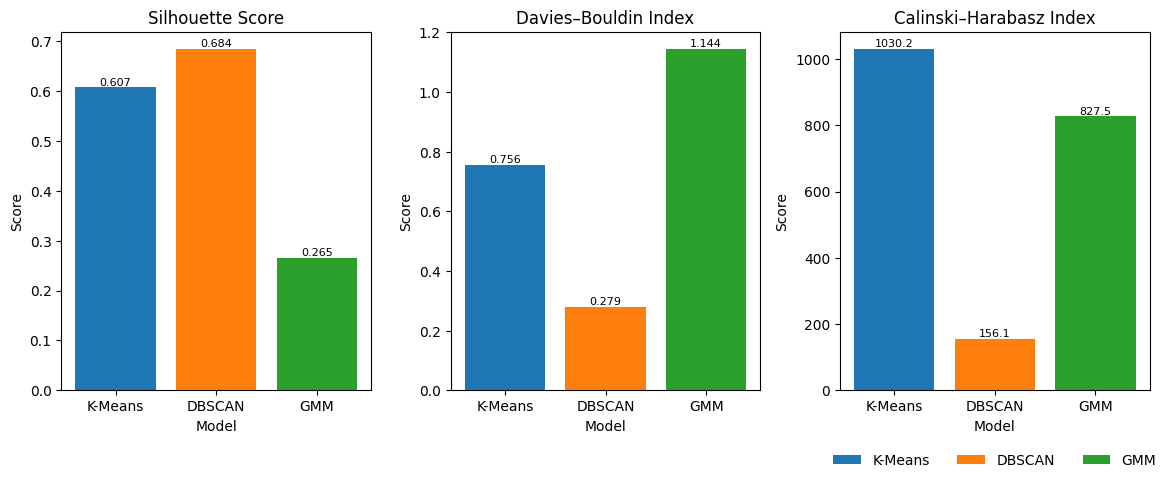

In [118]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# One colour per model
model_colors = {
    "K-Means": "#1f77b4",
    "DBSCAN": "#ff7f0e",
    "GMM": "#2ca02c"
}

models = scores_df["Model"]
silhouette = scores_df["Silhouette Score"]
dbi = scores_df["Davies-Bouldin"]
chi = scores_df["Calinski-Harabasz"]

colors = [model_colors[m] for m in models]

plt.figure(figsize=(12,5))

# Silhouette Score
plt.subplot(1, 3, 1)
bars1 = plt.bar(models, silhouette, color=colors)
plt.title("Silhouette Score")
plt.ylabel("Score")
plt.xlabel("Model")

for bar in bars1:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

# Davies Bouldin
plt.subplot(1, 3, 2)
bars2 = plt.bar(models, dbi, color=colors)
plt.title("Davies–Bouldin Index")
plt.ylabel("Score")
plt.xlabel("Model")

for bar in bars2:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.3f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

# Calinski Harabasz
plt.subplot(1, 3, 3)
bars3 = plt.bar(models, chi, color=colors)
plt.title("Calinski–Harabasz Index")
plt.ylabel("Score")
plt.xlabel("Model")

for bar in bars3:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width()/2,
        height,
        f"{height:.1f}",
        ha="center",
        va="bottom",
        fontsize=8
    )

legend_elements = [
    Patch(facecolor=model_colors["K-Means"], label="K-Means"),
    Patch(facecolor=model_colors["DBSCAN"], label="DBSCAN"),
    Patch(facecolor=model_colors["GMM"], label="GMM")
]

plt.legend(
    handles=legend_elements,
    loc="lower center",
    bbox_to_anchor=(0.5, -0.25),
    ncol=3,
    frameon=False
)

plt.tight_layout()
plt.show()


# Conclusion

The clustering results show that different algorithms capture different aspects of the climate data. K-Means provides the strongest global separation of climate patterns, DBSCAN identifies compact clusters and detects extreme or anomalous events, and GMM models overlapping and gradual transitions between climate regimes. Together, these methods provide a comprehensive understanding of the underlying structure of the Basel climate dataset.